In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
sonoma = pd.read_csv("../main_data/locale_specific_data/SonomaCountyData.csv")

### Summary

Data cleaning:
- drop unnecessary columns
- change index
- clean columns with .str(), .split(), .fillna(), .apply() [with context], 
- rename columns to combine with other datasets
- skip rows?

This data:
- WeekYear format for dates (mid 2000s - present)
- CountOf...
- intakes/outtakes statistics
- (Optional)

Observations:
- 884 breeds
- outcome_jurisdicition has inconsistent cities/towns (see below)

In [29]:
# replace column names: " " to "_" and change to lowercase
def remove_space(column_name):
    return column_name.lower().replace(' ','_')
sonoma = sonoma.rename(remove_space, axis = "columns")

# Only look at dogs
sonoma = sonoma.loc[sonoma.type == "DOG"]

# convert to datetime format
sonoma["intake_date"] = pd.to_datetime(sonoma["intake_date"])
sonoma["outcome_date"] = pd.to_datetime(sonoma["outcome_date"])

# "location" values are of the form zipcode(latitude,longitude)
# this function keeps only the zipcode of outcome jurisdiction
# there is already an "outcome_zip_code" column with float, I'm too lazy to modify it and will drop this column
def remove_lat_long(column_name):
    return str(column_name)[:5]
sonoma["zipcode"] = sonoma["location"].apply(remove_lat_long)

# outcome_jurisdicition has inconsistent cities/towns (see below)
def remove_ast(column_name):
    return str(column_name).replace("*","")
sonoma["outcome_jurisdiction"] = sonoma["outcome_jurisdiction"].apply(remove_ast)

In [30]:
sonoma.columns

Index(['name', 'type', 'breed', 'color', 'sex', 'size', 'date_of_birth',
       'impound_number', 'kennel_number', 'animal_id', 'intake_date',
       'outcome_date', 'days_in_shelter', 'intake_type', 'intake_subtype',
       'outcome_type', 'outcome_subtype', 'intake_condition',
       'outcome_condition', 'intake_jurisdiction', 'outcome_jurisdiction',
       'outcome_zip_code', 'location', 'count', 'zipcode'],
      dtype='object')

In [31]:
sonoma.intake_type.unique()

array(['TRANSFER', 'STRAY', 'OWNER SURRENDER', 'QUARANTINE',
       'ADOPTION RETURN', 'CONFISCATE', 'BORN HERE'], dtype=object)

In [32]:
# 1. Stray/Abandoned
# 2. Owner Surrender
# 3. Euthanasia Request
# 4. Public Assist (anything that involves intake for community (court ordered, police help, rabies quarantines)
# 5. Other/Transfers"

# transfer -> other
# stray -> stray_abandoned
# owner surrender -> owner_surrender
# quarantine -> public assist
# adoption return -> owner surrender
# confiscate -> public assist
# born here -> other

sonoma["stray_abandoned"] = 0
sonoma["owner_surrender"] = 0
sonoma["euthanasia"] = 0
sonoma["public_assist"] = 0
sonoma["other"] = 0

In [33]:
sonoma = sonoma.reset_index()

for index,row in sonoma.iterrows():
    if row["intake_type"] == "STRAY":
        sonoma.at[index,"stray_abandoned"] = 1
    elif row["intake_type"] == "OWNER SURRENDER" or row["intake_type"] == "ADOPTION RETURN":
        sonoma.at[index,"owner_surrender"] = 1
    elif row["intake_type"] == "QUARANTINE" or row["intake_type"] == "CONFISCATE":
        sonoma.at[index,"public_assist"] = 1
    else:
        sonoma.at[index,"other"] = 1


In [34]:
print(sum(sonoma["stray_abandoned"]))
print(sum(sonoma["owner_surrender"]))
print(sum(sonoma["euthanasia"]))
print(sum(sonoma["public_assist"]))
print(sum(sonoma["other"]))

11378
1803
0
2242
265


Adding a section to group by date, based on John's Cali code--Claire

In [73]:
CaliOutcome = sonoma

In [74]:
##Creating IntakesSum Column
CaliIntake['TotalIntakes'] = CaliIntake['stray_abandoned'] + CaliIntake['Euthanasia_Req'] + CaliIntake['Public_Assist'] + CaliIntake['Owner_Surrender'] + CaliIntake['Other']

In [75]:

##Making Vectors with counts per day for big dataset or smaller analyses
CaliStrayAbanbyDay = CaliIntake.groupby('intake_date')['stray_abandoned'].sum().reset_index()
CaliEuthRbyDay = CaliIntake.groupby('intake_date')['euthanasia'].sum().reset_index()
CaliPAbyDay = CaliIntake.groupby('intake_date')['public_assist'].sum().reset_index()
CaliSurrbyDay = CaliIntake.groupby('intake_date')['owner_surrender'].sum().reset_index()
CaliOtherbyDay = CaliIntake.groupby('intake_date')['other'].sum().reset_index()
CaliTotalIntakebyDay = CaliIntake.groupby('intake_date')['TotalIntakes'].sum().reset_index()

In [71]:
print(CaliStrayAbanbyDay)

     intake_date  stray_abandoned
0     2013-08-22                0
1     2013-08-31                1
2     2013-09-19                1
3     2013-10-01                0
4     2013-10-08                1
...          ...              ...
3450  2024-05-11                9
3451  2024-05-12                0
3452  2024-05-13                4
3453  2024-05-14                3
3454  2024-05-15                3

[3455 rows x 2 columns]


In [82]:
#Put the daily data into a Data Frame

CaliIntake = pd.concat([CaliStrayAbanbyDay, #both columns to include the date
                           CaliEuthRbyDay.iloc[:, 1], #only need counts, not date
                           CaliPAbyDay.iloc[:, 1],
                           CaliSurrbyDay.iloc[:, 1],
                           CaliOtherbyDay.iloc[:, 1],
                           CaliTotalIntakebyDay.iloc[:, 1]],
                           axis=1 #concatinate by columns instead of rows
                           )

CaliIntake.to_csv('../main_data/locale_specific_data/SonomaIntakeClean.csv')

In [62]:
print(CaliIntake['TotalIntakes'])

0        0
1        1
2        1
3        0
4        1
        ..
15683    1
15684    0
15685    1
15686    0
15687    1
Name: TotalIntakes, Length: 15688, dtype: int64


In [35]:
sonoma.outcome_type.unique()

array(['EUTHANIZE', 'ADOPTION', 'TRANSFER', 'RETURN TO OWNER', 'DIED',
       'ESCAPED/STOLEN', 'DISPOSAL', nan, 'RTOS', 'VET'], dtype=object)

In [36]:
# 1. Return to Owner
# 2. Adoption
# 3. Euthanasia
# 4. Unintended (Missing, Stolen, Died, Lost)
# 5. Other/Transfer

# EUTHANIZE -> euthanisasia
# ADOPTION -> adoption
# TRANSFER -> other
# RETURN TO OWNER -> return to owner
# DIED -> unintended
# ESCAPED/STOLEN -> unintended
# DISPOSAL -> unintended
# nan -> other
# RTOS -> return to owner
# VET -> other

sonoma["euthanised"] = 0
sonoma["adoption"] = 0
sonoma["return_to_owner"] = 0
sonoma["unintended"] = 0
sonoma["other"] = 0

In [37]:
sonoma = sonoma.reset_index()

for index,row in sonoma.iterrows():
    if row["outcome_type"] == "EUTHANIZE":
        sonoma.at[index,"euthanised"] = 1
    elif row["outcome_type"] == "ADOPTION":
        sonoma.at[index,"adoption"] = 1
    elif row["outcome_type"] == "RETURN TO OWNER" or row["outcome_type"] == "RTOS":
        sonoma.at[index,"return_to_owner"] = 1
    elif row["outcome_type"] == "DIED" or row["outcome_type"] == "ESCAPED/STOLEN" or row["outcome_type"] == "DISPOSAL":
        sonoma.at[index,"unintended"] = 1
    else:
        sonoma.at[index,"other"] = 1

In [38]:
print(sum(sonoma["euthanised"]))
print(sum(sonoma["adoption"]))
print(sum(sonoma["return_to_owner"]))
print(sum(sonoma["unintended"]))
print(sum(sonoma["other"]))

1729
3615
7851
76
2417


Adding a section to group by date, based on John's Cali code--Claire

In [76]:
CaliOutcome = sonoma
##Creating Outcomes Sum Column
CaliOutcome['TotalIntakes'] = CaliOutcome['euthanised'] + CaliOutcome['adoption'] + CaliOutcome['return_to_owner'] + CaliOutcome['unintended'] + CaliOutcome['other']

In [78]:
##Creating total vectorsdata

CaliAdoptbyDay = CaliOutcome.groupby('outcome_date')['adoption'].sum().reset_index()
CaliEuthbyDay = CaliOutcome.groupby('outcome_date')['euthanised'].sum().reset_index()
CaliRTObyDay = CaliOutcome.groupby('outcome_date')['return_to_owner'].sum().reset_index()
CaliUnintbyDay = CaliOutcome.groupby('outcome_date')['unintended'].sum().reset_index()
CaliOtherOutbyDay = CaliOutcome.groupby('outcome_date')['other'].sum().reset_index()
CaliTotalOutbyDay = CaliOutcome.groupby('outcome_date')['TotalOutcomes'].sum().reset_index()

In [83]:
print(CaliAdoptbyDay)

     outcome_date  adoption
0      2014-01-01         0
1      2014-01-02         4
2      2014-01-03         5
3      2014-01-04         3
4      2014-01-05         0
...           ...       ...
2915   2024-05-10         0
2916   2024-05-11         2
2917   2024-05-13         0
2918   2024-05-14         0
2919   2024-05-15         0

[2920 rows x 2 columns]


In [84]:
#Put the daily data into a Data Frame

CaliOutcome = pd.concat([CaliAdoptbyDay, #both columns to include the date
                           CaliEuthbyDay.iloc[:, 1], #only need counts, not date
                           CaliRTObyDay.iloc[:, 1],
                           CaliUnintbyDay.iloc[:, 1],
                           CaliOtherOutbyDay.iloc[:, 1],
                           CaliTotalOutbyDay.iloc[:, 1]],
                           axis=1 #concatinate by columns instead of rows
                           )

CaliOutcome.to_csv('../main_data/locale_specific_data/SonomaOutcomesClean.csv')

In [39]:
# replace values with np.nan
sonoma = sonoma.replace({np.nan: np.nan,"NaN": np.nan, "nan": np.nan, "Unknown": np.nan,"UNKNOWN":np.nan})

In [40]:
# create a new dataframe consisting of "date", "# of intakes", "# of outcomes"

# range of dates
date_min = min(min(sonoma["intake_date"]),min(sonoma["outcome_date"]))
date_max = max(max(sonoma["intake_date"]),max(sonoma["outcome_date"]))

In [41]:
sonoma_count = pd.DataFrame({'date':pd.date_range(date_min,date_max)})
sonoma_count["intakes"] = 0

intake_df = pd.DataFrame(sonoma["intake_date"].value_counts().reset_index())
intake_df = intake_df.rename(columns={"intake_date":"date","count":"intakes"})
sonoma_count = pd.merge(sonoma_count,intake_df,on=["date"])

outcome_df = pd.DataFrame(sonoma["outcome_date"].value_counts().reset_index())
outcome_df = outcome_df.rename(columns={"outcome_date":"date","count":"outcomes"})
sonoma_count = sonoma_count.set_index('date').join(outcome_df.set_index('date')).fillna(0).astype(int)

sonoma_count = sonoma_count.drop(columns=['intakes_x'])
sonoma_count = sonoma_count.rename(columns = {"intakes_y":"intakes"}).reset_index()


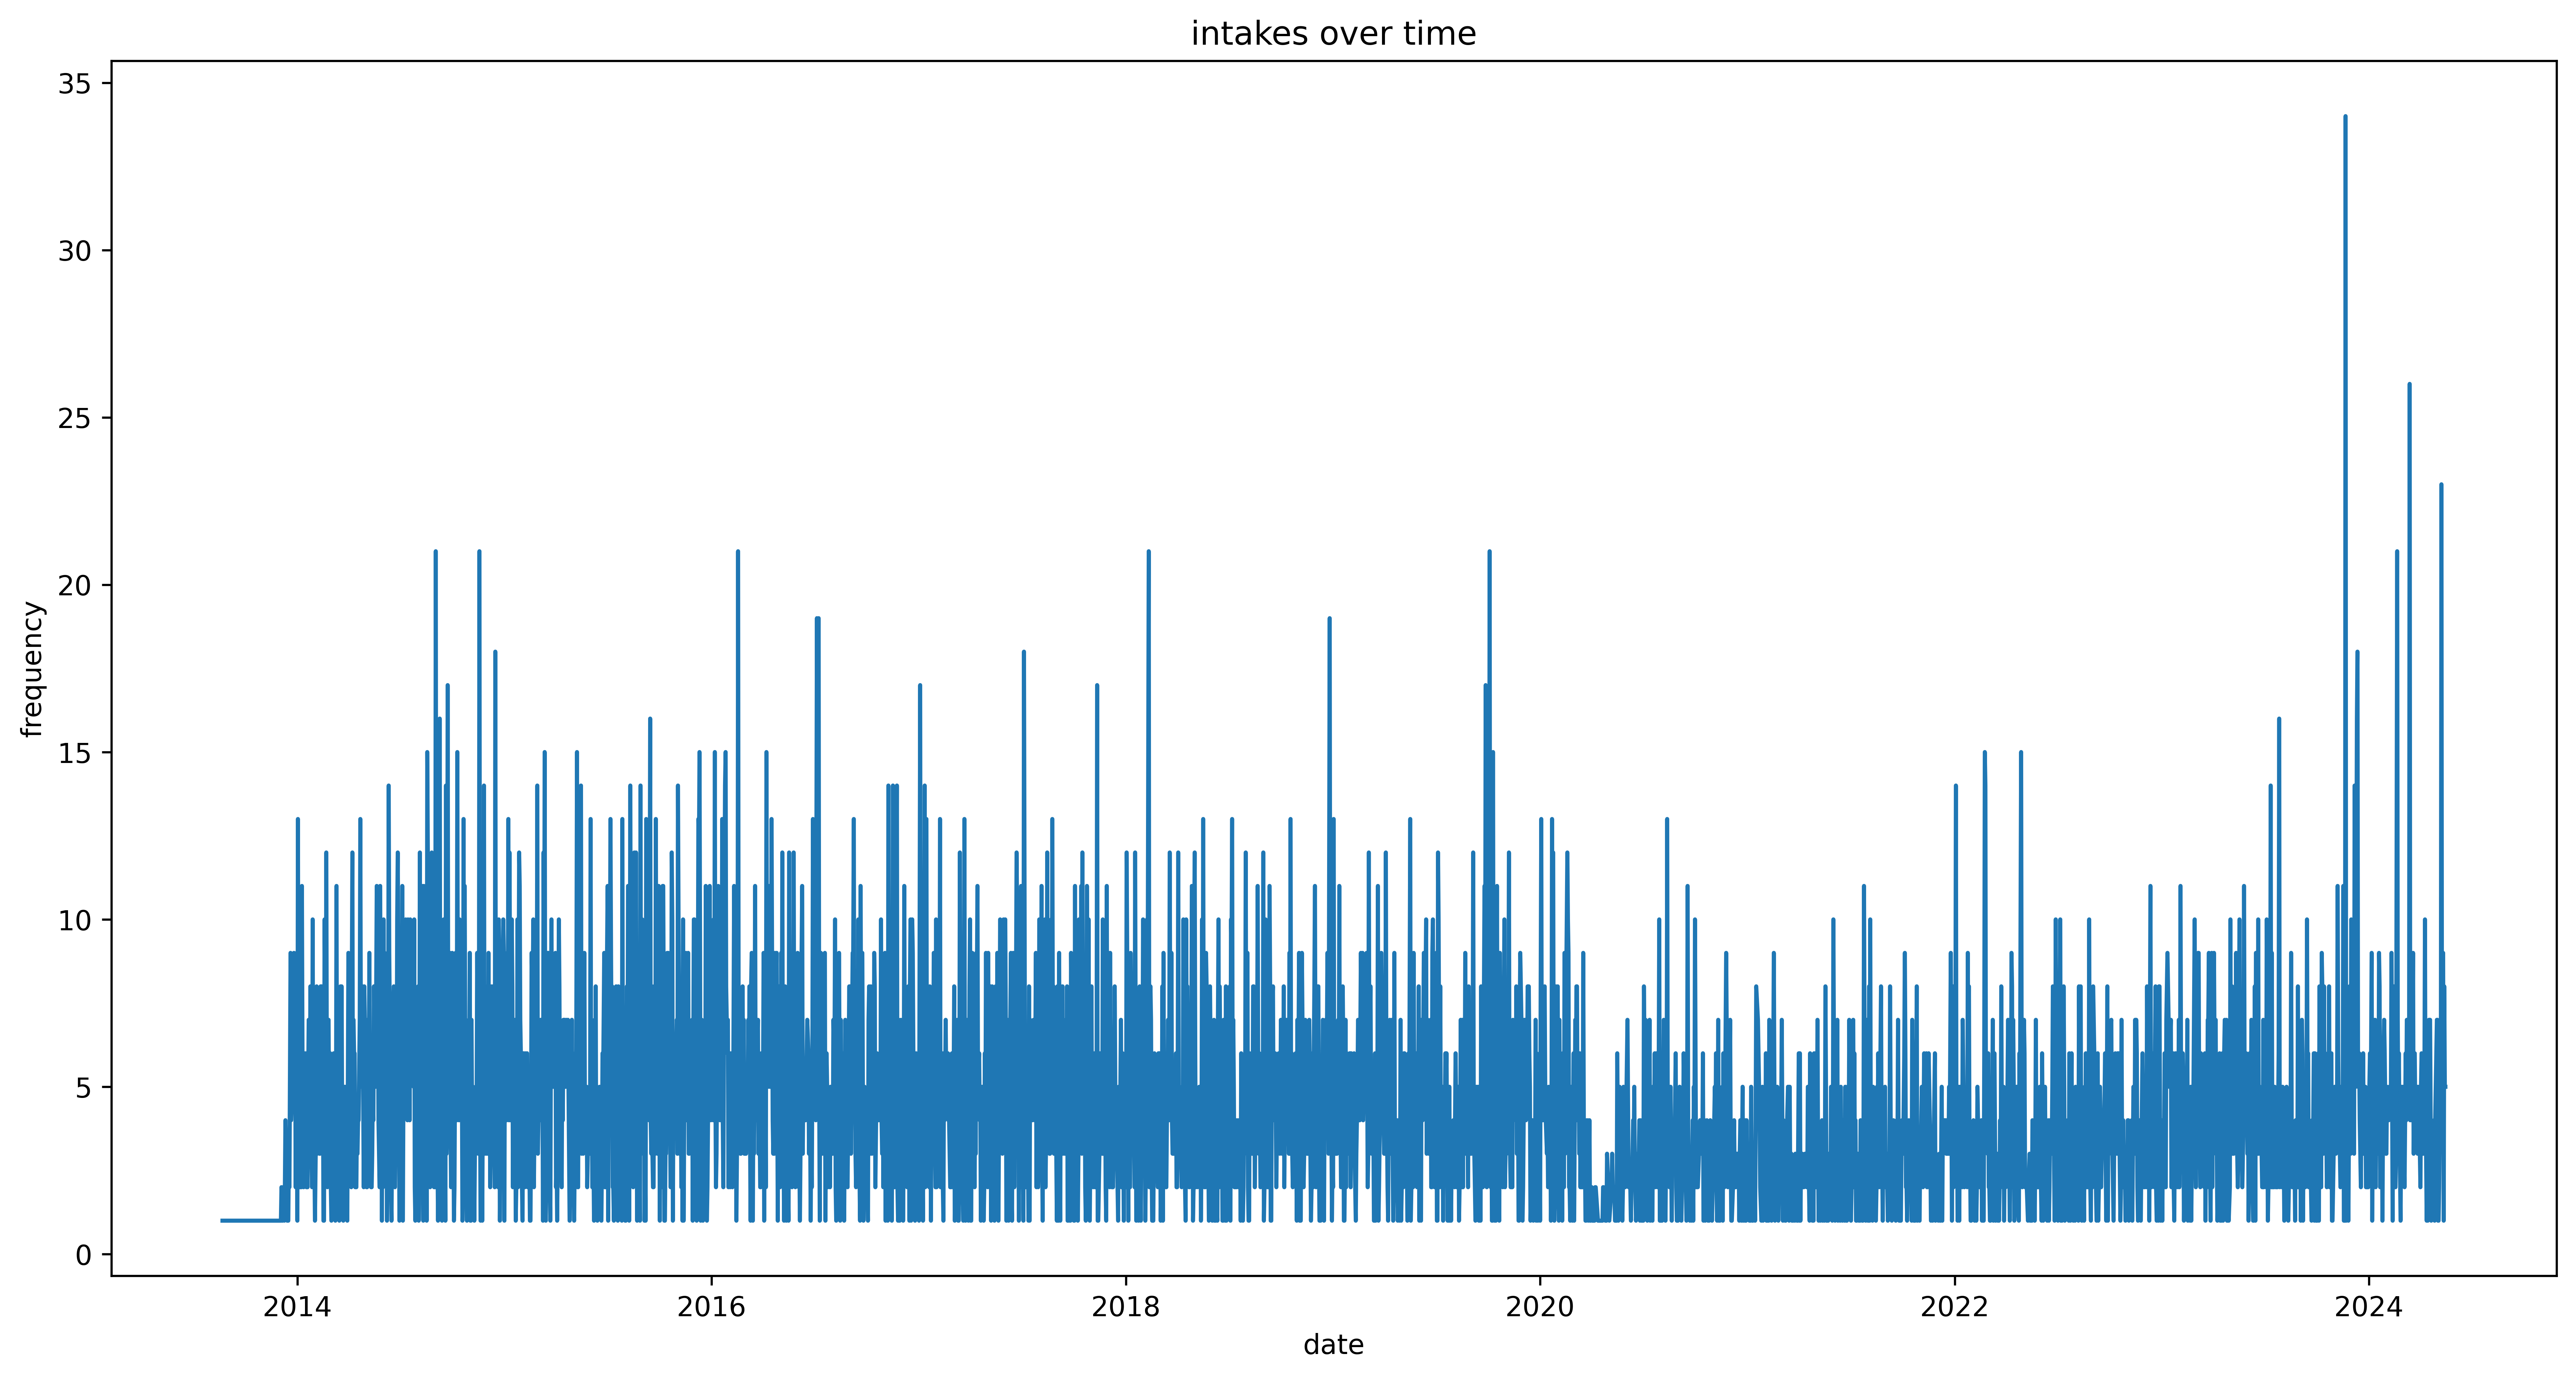

In [42]:
plt.figure(figsize = (16,8), dpi = 600)

plt.plot(sonoma_count["date"], sonoma_count["intakes"])

plt.title("intakes over time")

plt.xlabel("date")
plt.ylabel("frequency")

plt.show()

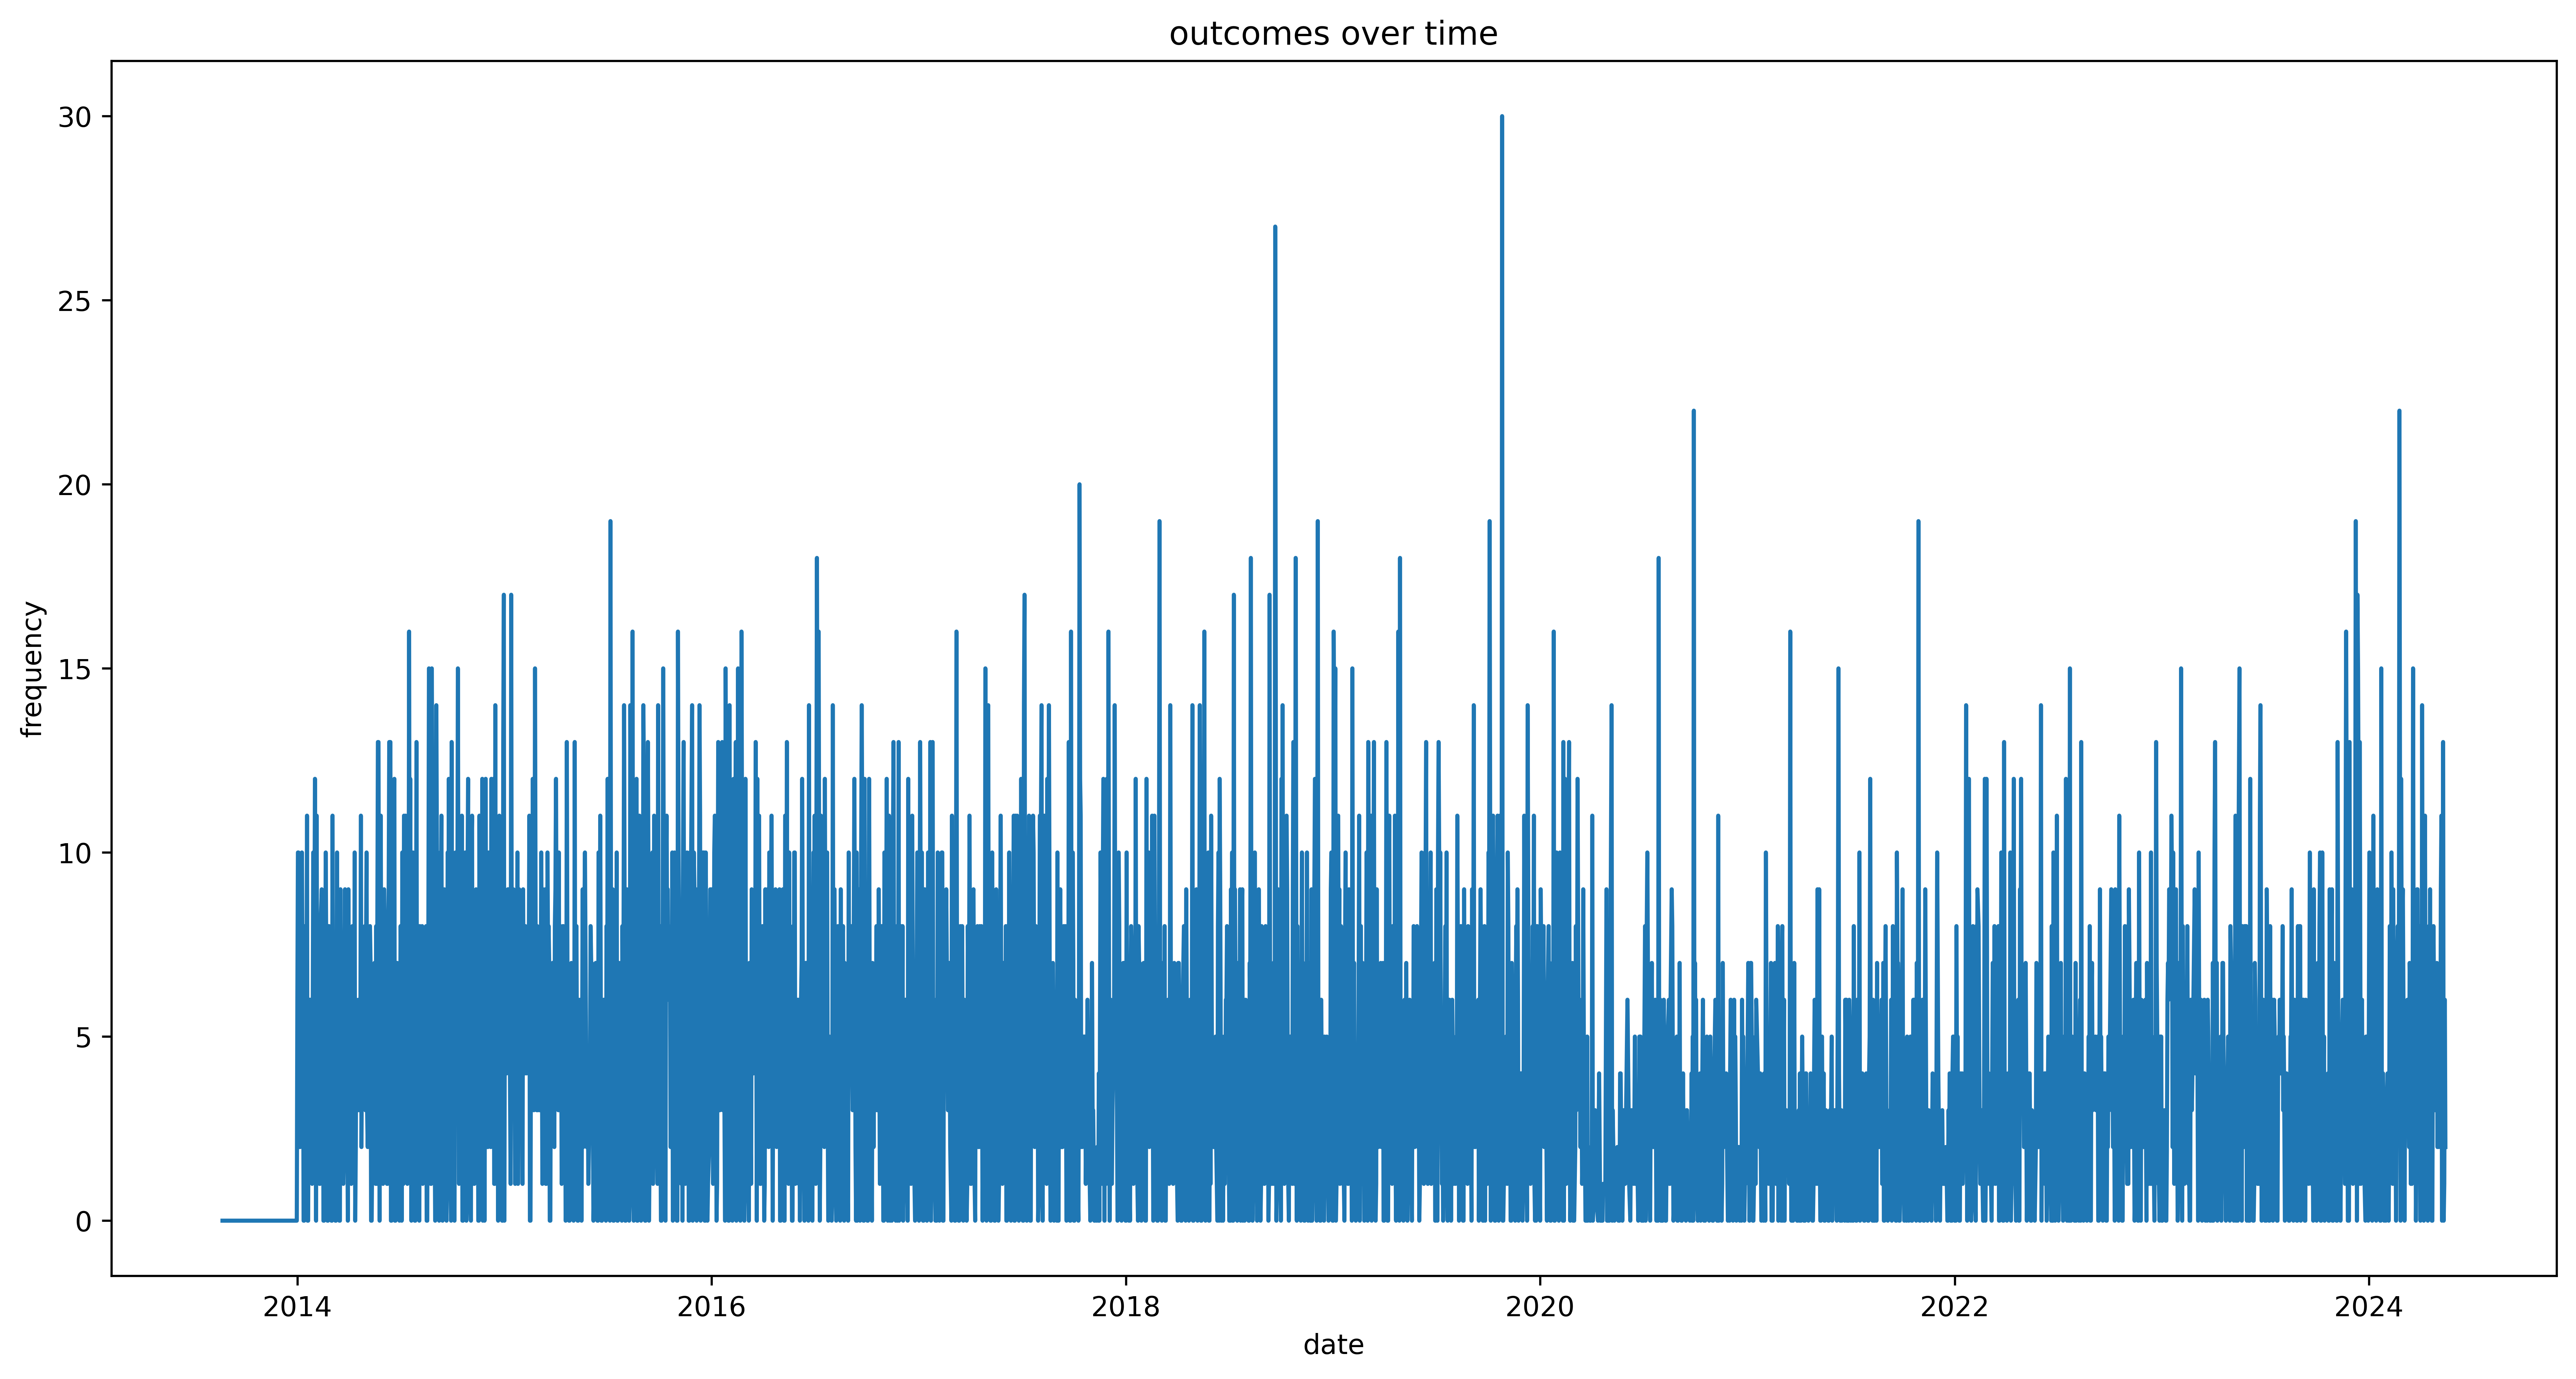

In [43]:
plt.figure(figsize = (16,8), dpi = 600)

plt.plot(sonoma_count["date"], sonoma_count["outcomes"])

plt.title("outcomes over time")

plt.xlabel("date")
plt.ylabel("frequency")

plt.show()

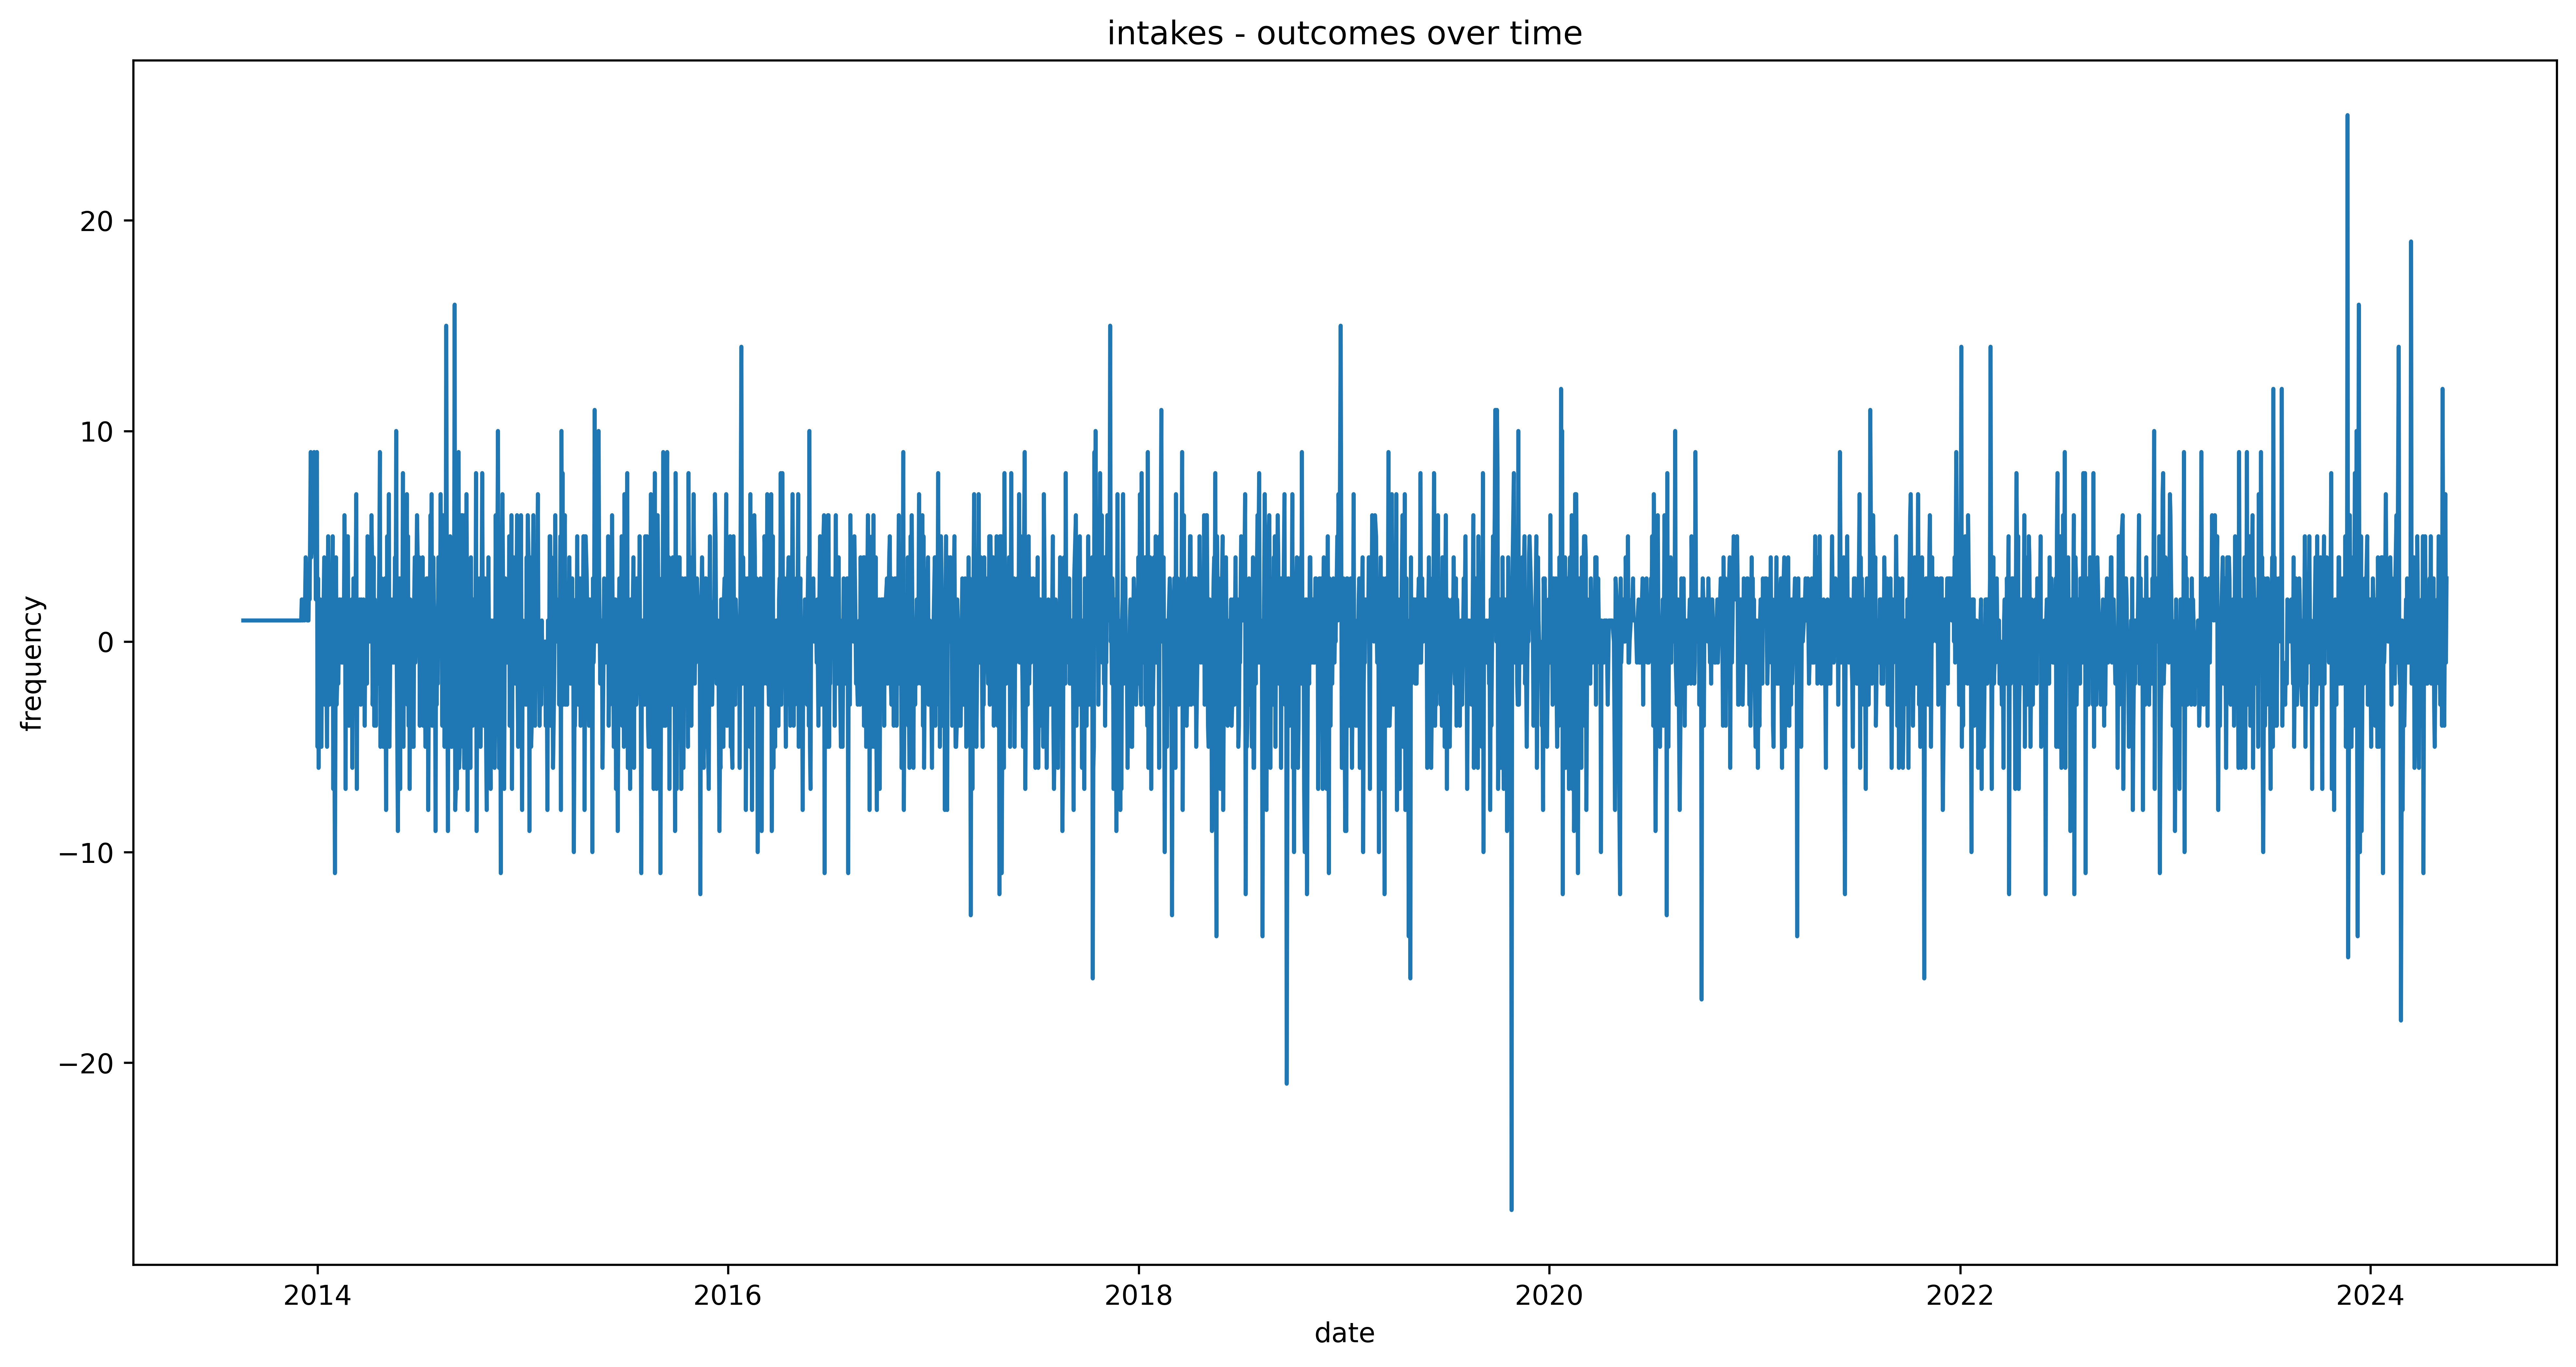

In [44]:
plt.figure(figsize = (16,8), dpi = 600)

plt.plot(sonoma_count["date"], sonoma_count["intakes"] - sonoma_count["outcomes"])

plt.title("intakes - outcomes over time")

plt.xlabel("date")
plt.ylabel("frequency")

plt.show()

In [45]:
# outcome_subtype has a lot of noisy data
# to_drop = ["name","type","breed","color","impound_number","kennel_number","animal_id","intake_jurisdiction","outcome_jurisdiction","outcome_zip_code","location","count"]
# sonoma = sonoma.drop(to_drop,axis =1)

In [46]:
# function that takes date to weekyear: '01/08/2024' -> '2-2024'
def weekyear_converter(column_name):
    return str(pd.Timestamp(column_name).weekofyear) + "-" + str(pd.Timestamp(column_name).year)

sonoma["intake_date_week_year"] = sonoma["intake_date"].apply(weekyear_converter)
sonoma["outcome_date_week_year"] = sonoma["outcome_date"].apply(weekyear_converter)

In [47]:
# create CountOf.....

# Example
sonoma_count = sonoma["intake_date_week_year"].value_counts().rename_axis("week_year").to_frame("intakes")
sonoma_count["outcomes"] = sonoma["outcome_date_week_year"].value_counts().astype('Int64')
sonoma_count = sonoma_count.fillna(0)